The following codes come from tutorials provided by [Qiskit](https://learn.qiskit.org/course/machine-learning).

## Parameterized quantum circuits

### Introduction

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

In [2]:
theta = Parameter('θ')

In [3]:
qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0 ,1)

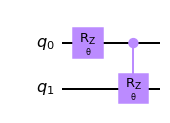

In [4]:
qc.draw(output='mpl')

In [5]:
from qiskit.circuit import ParameterVector

theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw()

┌──────────┐            
q_0: ┤ Rz(θ[0]) ├─────■──────
     └──────────┘┌────┴─────┐
q_1: ────────────┤ Rz(θ[1]) ├
                 └──────────┘

#### Expressivity

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

In [8]:
qc_A.draw()

┌───┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├
   └───┘└───────┘

In [9]:
qc_B.draw()

┌───┐┌───────┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├┤ Rx(Φ) ├
   └───┘└───────┘└───────┘

In [10]:
# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

In [11]:
# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

In [12]:
def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

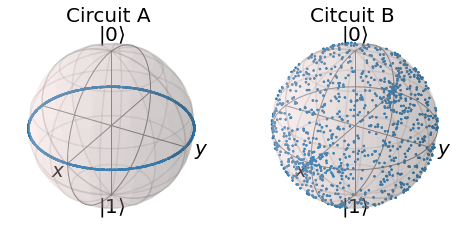

In [18]:
# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))
    
b1.show(title='Circuit A')
b2.show(title='Citcuit B')

#### Entangling capability

The Meyer-Wallach measure of an unentangled product state is 0, while the Meyer-Wallach measure of a highly entangled state, such as the Bell state, is 1.

### Parameterized quantum circuits for machine learning

In [19]:
from qiskit.circuit.library import ZZFeatureMap

qc_zz = ZZFeatureMap(3, reps=1, insert_barriers=True)

qc_zz.decompose().draw()

┌───┐ ░ ┌─────────────┐                                               »
q_0: ┤ H ├─░─┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤ ░ ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├─░─┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤ ░ ├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├─░─┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘ ░ └─────────────┘                                          └───┘»
«                                               »
«q_0: ──────────────────────────────────■───────»
«                                       │       »
«q_1: ──────────────────────────────────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├»
«     └──────────────────────────────┘└───┘└───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├
«     └──────────────────────────────┘└───┘

In [20]:
from qiskit.circuit.library import TwoLocal

qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw()

┌──────────┐┌──────────┐ ░           ░ ┌──────────┐ ┌──────────┐ ░       »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░──■──■─────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├─░──■──■─»
     ├──────────┤├──────────┤ ░  │  │     ░ ├──────────┤┌┴──────────┤ ░  │  │ »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░──■──┼──■──░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├─░──■──┼─»
     ├──────────┤├──────────┤ ░     │  │  ░ ├──────────┤├───────────┤ ░     │ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░─────■──■──░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─░─────■─»
     └──────────┘└──────────┘ ░           ░ └──────────┘└───────────┘ ░       »
«        
«q_0: ───
«        
«q_1: ─■─
«      │ 
«q_2: ─■─
«

## Data Encoding

### Basis encoding

In Qiskit, once we calculate what state will encode our dataset, we can use the initialize function to prepare it. For example, the dataset $\mathscr{X}=\left\{x^{(1)}=101, x^{(2)}=111\right\}$ is encoded as the state

$$
|\mathscr{X}\rangle=\frac{1}{\sqrt{2}}(|101\rangle+|111\rangle):
$$

In [27]:
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().decompose().draw()

┌─────────┐                           ┌───┐┌───────┐┌───┐┌───────┐»
q_0: ─|0>──┤ Ry(π/2) ├───────────────────────────┤ X ├┤ Ry(0) ├┤ X ├┤ Ry(0) ├»
          ┌┴─────────┴─┐┌───┐┌─────────────┐┌───┐└─┬─┘└───────┘└─┬─┘└───────┘»
q_1: ─|0>─┤ R(π/4,π/2) ├┤ X ├┤ R(-π/4,π/2) ├┤ X ├──■─────────────┼───────────»
          ├───────────┬┘└─┬─┘└─────────────┘└─┬─┘                │           »
q_2: ─|0>─┤ U3(π,0,0) ├───■───────────────────■──────────────────■───────────»
          └───────────┘                                                      »
«     ┌───┐┌──────────┐┌───┐
«q_0: ┤ X ├┤ Ry(-π/2) ├┤ X ├
«     └─┬─┘└──────────┘└─┬─┘
«q_1: ──■────────────────┼──
«                        │  
«q_2: ───────────────────■──
«

### Amplitude encoding

As an example, let's encode the dataset $\mathscr{X}=\left\{x^{(1)}=(1.5,0), x^{(2)}=(-2,3)\right\}$ using amplitude encoding. Concatenating both data points and normalizing the resulting vector, we get:

$$
\alpha=\frac{1}{\sqrt{15.25}}(1.5,0,-2,3)
$$

and the resulting 2 -qubit quantum state would be:

$$
|\mathscr{X}\rangle=\frac{1}{\sqrt{15.25}}(1.5|00\rangle-2|10\rangle+3|11\rangle)
$$

In the example above, the total number of elements of the amplitude vector, $N \times M$, is a power of 2 . When $N \times M$ is not a power of 2 , we can simply choose a value for $n$ such that $2^{n} \geq M N$ and pad the amplitude vector with uninformative constants.

In [30]:
desired_state = [
    1 / math.sqrt(15.25) * 1.5,
    0,
    1 / math.sqrt(15.25) * -2,
    1 / math.sqrt(15.25) * 3]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0,1])

qc.decompose().decompose().decompose().decompose().decompose().decompose().draw()

┌────────────────┐               ┌───┐┌─────────────────┐┌─────────┐»
q_0: ─|0>─┤ R(0.98279,π/2) ├───────────────┤ X ├┤ R(-0.98279,π/2) ├┤ U1(π/2) ├»
          ├────────────────┤┌─────────────┐└─┬─┘└─────────────────┘└─────────┘»
q_1: ─|0>─┤ U3(2.3531,0,0) ├┤ U3(0,0,π/2) ├──■────────────────────────────────»
          └────────────────┘└─────────────┘                                   »
«     ┌───┐┌──────────┐
«q_0: ┤ X ├┤ U1(-π/2) ├
«     └─┬─┘└──────────┘
«q_1: ──■──────────────
«

The advantage of amplitude encoding is that it only requires $\log _{2}(N M)$ qubits to encode. However, subsequent algorithms must operate on the amplitudes of a quantum state, and methods to prepare and measure the quantum states tend not to be efficient.

### Angle encoding

We can specify angle encoding as a unitary:

$$
S_{x_{j}}=\bigotimes_{i=1}^{N} U\left(x_{j}^{(i)}\right)
$$

where:

$$
U\left(x_{j}^{(i)}\right)=\left[\begin{array}{cc}
\cos \left(x_{j}^{(i)}\right) & -\sin \left(x_{j}^{(i)}\right) \\
\sin \left(x_{j}^{(i)}\right) & \cos \left(x_{j}^{(i)}\right)
\end{array}\right]
$$

Remembering that a single-qubit rotation around the $Y$-axis is:

$$
R Y(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right)
$$

We note that $U\left(x_{j}^{(i)}\right)=R Y\left(2 x_{j}^{(i)}\right)$, and as an example, encode the datapoint $x=(0, \pi / 4, \pi / 2)$ using qiskit:

In [31]:
qc = QuantumCircuit(3)

qc.ry(0, 0)
qc.ry(math.pi/4, 1)
qc.ry(math.pi/2, 2)
qc.draw()

┌───────┐ 
q_0: ─┤ Ry(0) ├─
     ┌┴───────┴┐
q_1: ┤ Ry(π/4) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     └─────────┘

### Arbitary Encoding

Arbitrary encoding encodes $N$ features as rotations on $N$ parameterized gates on $n$ qubits, where $n \leq N$.

For example, to use the Qiskit EfficientSU2 circuit to encode 12 features, would only use 3 qubits:

In [32]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw()

┌──────────┐┌──────────┐ ░                 ░ ┌──────────┐ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░───■────■────────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
     ├──────────┤├──────────┤ ░ ┌─┴─┐  │        ░ ├──────────┤┌┴──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░─┤ X ├──┼────■───░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──────┤ X ├┤ X ├─░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘ ░      └───┘└───┘ ░ └──────────┘└───────────┘

In [33]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

encode = circuit.bind_parameters(x)
encode.decompose().draw()

┌─────────┐┌─────────┐ ░                 ░ ┌─────────┐┌─────────┐
q_0: ┤ Ry(0.1) ├┤ Rz(0.4) ├─░───■────■────────░─┤ Ry(0.7) ├┤ Rz(1.0) ├
     ├─────────┤├─────────┤ ░ ┌─┴─┐  │        ░ ├─────────┤├─────────┤
q_1: ┤ Ry(0.2) ├┤ Rz(0.5) ├─░─┤ X ├──┼────■───░─┤ Ry(0.8) ├┤ Rz(1.1) ├
     ├─────────┤├─────────┤ ░ └───┘┌─┴─┐┌─┴─┐ ░ ├─────────┤├─────────┤
q_2: ┤ Ry(0.3) ├┤ Rz(0.6) ├─░──────┤ X ├┤ X ├─░─┤ Ry(0.9) ├┤ Rz(1.2) ├
     └─────────┘└─────────┘ ░      └───┘└───┘ ░ └─────────┘└─────────┘

## Training parameterized quantum circuits

### Gradients

First, we need to define our parameterized state, $|\Psi(\vec{\theta})\rangle=U(\vec{\theta})|00 \ldots 0\rangle$. In this page, $U(\vec{\theta})$ is the Qiskit RealAmplitudes circuit on two qubits:

In [2]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear').decompose()
ansatz.draw()

┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

Next we need to define a Hamiltonian, let's use: $\hat{H}=\hat{Z} \bigotimes \hat{Z}$

In [3]:
from qiskit.opflow import Z, I

hamiltonian = Z ^ Z

Putting them together to make the expectation value: $\langle\Psi(\vec{\theta})|\hat{H}| \Psi(\vec{\theta})\rangle$

In [4]:
from qiskit.opflow import StateFn, PauliExpectation

expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we write a function to simulate the measurement of the expectation value:

In [39]:
ansatz.num_parameters

4

In [40]:
ansatz.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])])

In [5]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(pauli_basis, params=value_dict).eval()  
    return np.real(result)

In [6]:
import numpy as np

point = np.random.random(ansatz.num_parameters)
index = 2

#### FD gradients

$\vec{\nabla} f(\vec{\theta}) \approx \frac{1}{2 \epsilon}(f(\vec{\theta}+\epsilon)-f(\vec{\theta}-\epsilon))$

In [7]:
print(point)

[0.63588049 0.35762409 0.13239341 0.21470747]


In [8]:
np.identity(point.size)[:, index]

array([0., 0., 1., 0.])

In [9]:
dict(zip(ansatz.parameters, point))

{ParameterVectorElement(θ[0]): 0.6358804941116016,
 ParameterVectorElement(θ[1]): 0.3576240942184118,
 ParameterVectorElement(θ[2]): 0.13239341146715544,
 ParameterVectorElement(θ[3]): 0.21470747458523853}

In [10]:
%%time

eps = 0.2
# make identity vector with a 1 at index ``index``, otherwise 0
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)
print(finite_difference)

0.009765625
CPU times: user 465 ms, sys: 91.4 ms, total: 556 ms
Wall time: 2.27 s


#### Qiskit Gradient class for FD

In [11]:
from qiskit.opflow import Gradient

In [12]:
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


0.0115966796875

#### Analytic gradients and parameter shift rule

Analytics gradients evaluate the analytic formula for the gradients. In general, that is fairly difficult, because we have to do a manual calculation, but for circuit based gradients, there's a very nice theoretical result that gives us a very easy formula for calculating gradients - the parameter shift rule first introduced in Reference 1
For a simple circuit consisting of only Pauli rotations, without any coefficients, then this rule says that the analytic gradient is:

$\frac{\partial f}{\partial \theta_{i}}=\frac{f\left(\vec{\theta}+\frac{\pi}{2} \vec{e}_{i}\right)-f\left(\vec{\theta}-\frac{\pi}{2} \vec{e}_{i}\right)}{2} \longleftarrow$ Parameter Shift rule simplified

which is very similar to the equation for finite difference gradients.

In [13]:
eps = np.pi / 2
e_i = np.identity(point.size)[:, index]

plus = point + eps * e_i
minus = point - eps * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.0198974609375


In [14]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.012084960937499972

In [15]:
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)
grad = shifter.convert(expectation, params=ansatz.parameters[index])
sampler.convert(grad, value_dict).eval().real

0.007693525081102345

#### Gradient descent analytical

In [16]:
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

In [23]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

In [24]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_callback)

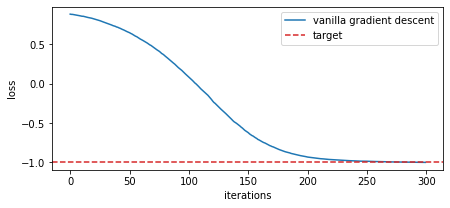

In [25]:
x_opt, fx_opt, nfevs = gd.optimize(
    initial_point.size,    # number of parameters
    evaluate_expectation,  # function to minimize
    gradient_function=evaluate_gradient,  # function to evaluate gradient
    initial_point=initial_point  # initial point
)

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 3))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### Gradient Descent FD -- bad results

In [20]:
gradient = Gradient('fin_diff', analytic=False).convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

In [21]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_callback)

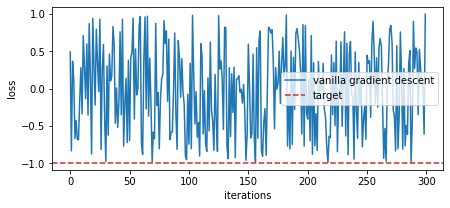

In [22]:
x_opt, fx_opt, nfevs = gd.optimize(
    initial_point.size,    # number of parameters
    evaluate_expectation,  # function to minimize
    gradient_function=evaluate_gradient,  # function to evaluate gradient
    initial_point=initial_point  # initial point
)

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 3))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### Natural Gradient

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
from qiskit.opflow import NaturalGradient

natural_gradient = (NaturalGradient(regularization='ridge')
                    .convert(expectation))
natural_gradient_in_pauli_basis = PauliExpectation().convert(
                                                    natural_gradient)
sampler = CircuitSampler(quantum_instance, caching="all")

def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result)

print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587051 -0.86457334 -0.98086453 -0.33820309]


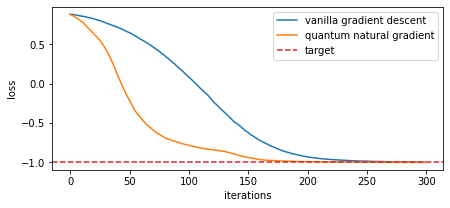

In [38]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)

qng = GradientDescent(maxiter=300,
                      learning_rate=0.01,
                      callback=qng_callback)

x_opt, fx_opt, nfevs = (
    qng.optimize(initial_point.size, 
                 evaluate_expectation, 
                 gradient_function=evaluate_natural_gradient,
                 initial_point=initial_point))

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### SPSA -- approximate the gradients (Use this?)

Don't need any gradient function here, use out-of-box

Simultaneous Perturbation Stochastic Approximation (SPSA) is an optimization technique where we randomly sample from the gradient, to reduce the number of evaluations. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well.

In practise, while the exact gradient follows a smooth path to the minimum, SPSA will jump around due to the random sampling, but it will converge, given the same boundary conditions as the gradient.

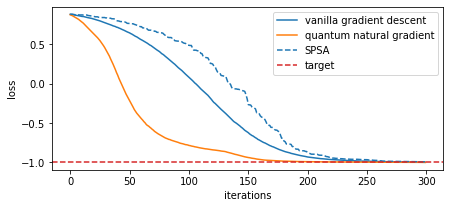

In [39]:
from qiskit.algorithms.optimizers import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01,
            perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

#### QNSPSA

We can do the same for natural gradients as well, as described in Reference 3. We'll skip the details here, but the idea is to sample not only from the gradient, but to extend this to the quantum Fisher information and thus to the natural gradient.

Qiskit implements this as the QNSPSA algorithm. Let's compare its performance:

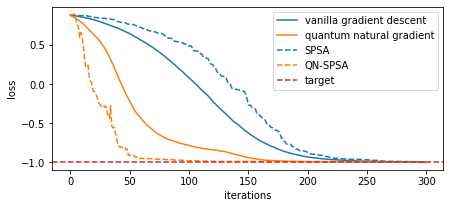

In [40]:
from qiskit.algorithms.optimizers import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz,
                               quantum_instance,
                               expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01,
                                       perturbation=0.01,
                                       callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

#### Decrease learning rate in practice

Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

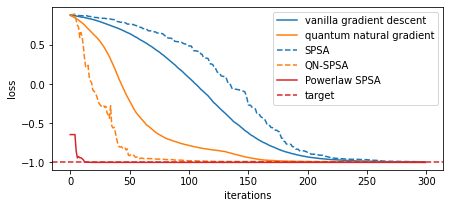

In [41]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300,
                learning_rate=None,
                perturbation=None,
                callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

# Plot loss
plt.figure(figsize=(7, 3))
plt.plot(gd_loss, 'C0', label='vanilla gradient descent')
plt.plot(qng_loss, 'C1', label='quantum natural gradient')
plt.plot(spsa_loss, 'C0', ls='--', label='SPSA')
plt.plot(qnspsa_loss, 'C1', ls='--', label='QN-SPSA')
plt.plot(autospsa_loss, 'C3', label='Powerlaw SPSA')
plt.axhline(-1, c='C3', ls='--', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

### Limitation -- Barren plateau

In [42]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and
    ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient
    of the first RY rotation gate.
    """
    index = num_qubits - 1

    # local or global operator
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator,
                          is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation,
                              params=ansatz.parameters[index])
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())

    return grads

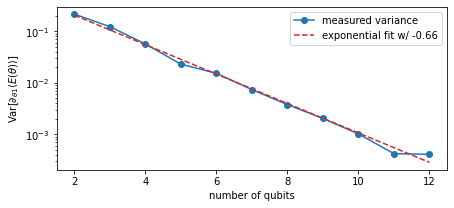

In [43]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='measured variance')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best');

Oh no! The variance decreases exponentially! This means our gradients contain less and less information and we'll have a hard time to train the model. This is known as the "barren plateau problem", or "exponentially vanishing gradients", discussed in detail in References 4 and 5.

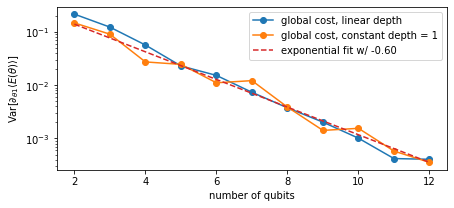

In [45]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients,
                                           axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits,
             np.var(gradients, axis=1),
             'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1),
             'o-',
             label='global cost, constant depth = 1')
plt.semilogy(x,
             np.exp(fit[0] * x + fit[1]),
             '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1}\langle E(\theta)\rangle]$')
plt.legend(loc='best')

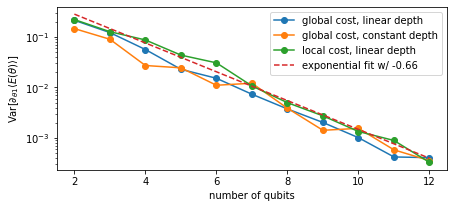

In [46]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n,
                                            local=True) for n in num_qubits]  

fit = np.polyfit(num_qubits,
                 np.log(np.var(linear_depth_local_gradients,axis=1)),
                 deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-',
             label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-',
             label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3',
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

In [ ]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1,
                                            local=True) for n in num_qubits]  

fit = np.polyfit(num_qubits,
                 np.log(np.var(fixed_depth_local_gradients, axis=1)),
                 deg=1)

x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(7, 3))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-',
             label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-',
             label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-',
             label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', 
             label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), '--', c='C3', 
             label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

--> Do layerwise training.

Sounds trivial, or be similar to the Res-Net idea